# Simple Collision Track Analysis

## Imports

In [1]:
from matplotlib import pyplot as plt
import openmc
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any

import scienceplots
plt.style.use(['science', 'notebook', 'grid', 'high-vis'])  # 'high-vis' 'grid' 'notebook' 'science' 'bright'

## Loading the data

In [2]:
data: Any = openmc.read_collision_track_file("../data/simple_collision_track/collision_track.h5")

df = pd.DataFrame(
    {
        "r_x": data["r"]["x"],
        "r_y": data["r"]["y"],
        "r_z": data["r"]["z"],
        "u_x": data["u"]["x"],
        "u_y": data["u"]["y"],
        "u_z": data["u"]["z"],
        "E": data["E"],
        "dE": data["dE"],
        "time": data["time"],
        "wgt": data["wgt"],
        "event_mt": data["event_mt"],
        "delayed_group": data["delayed_group"],
        "cell_id": data["cell_id"],
        "nuclide_id": data["nuclide_id"],
        "material_id": data["material_id"],
        "universe_id": data["universe_id"],
        "n_collision": data["n_collision"],
        "particle": data["particle"],
        "parent_id": data["parent_id"],
        "progeny_id": data["progeny_id"],
    }
)

print(len(df))
df.head()


780284


,r_x,r_y,r_z,u_x,u_y,u_z,E,dE,time,wgt,event_mt,delayed_group,cell_id,nuclide_id,material_id,universe_id,n_collision,particle,parent_id,progeny_id
0,-0.791140,-26.008911,1.880226,-0.238602,-0.940078,0.243564,2.919109e+06,193486.101095,0.000595,1.0,2,0,3,50100,2,1,1,0,8502,44
1,-0.877363,-26.348623,1.968242,-0.155759,-0.937377,0.311550,2.725623e+06,3153.725800,0.000595,1.0,2,0,3,50100,2,1,2,0,8502,44
2,-0.883827,-26.387523,1.981171,-0.155759,-0.937377,0.311550,2.722469e+06,0.000000,0.000595,0.0,101,0,3,50100,2,1,3,0,8502,44
3,4.623090,-28.873407,1.533844,-0.416499,-0.881996,0.220481,1.744763e+00,0.000000,0.000090,0.0,101,0,3,50100,2,1,16,0,6507,8
4,-1.131363,-25.360167,1.478886,0.469641,-0.846855,-0.249545,1.007280e+01,0.000000,0.000278,0.0,101,0,3,50100,2,1,21,0,7006,4


In [3]:
timestamps = np.sort(df["time"].values)

detector1_times = timestamps[df["cell_id"] == 2]
detector2_times = timestamps[df["cell_id"] == 3]

## Export raw data to excel

In [ ]:
out_dir = Path("../results/data")
out_dir.mkdir(parents=True, exist_ok=True)

out_file = out_dir / "collision_track_raw.xlsx"
df.to_excel(out_file, index=False)
print(f"Saved {len(df)} rows to {out_file}")

## Plotting a histogram

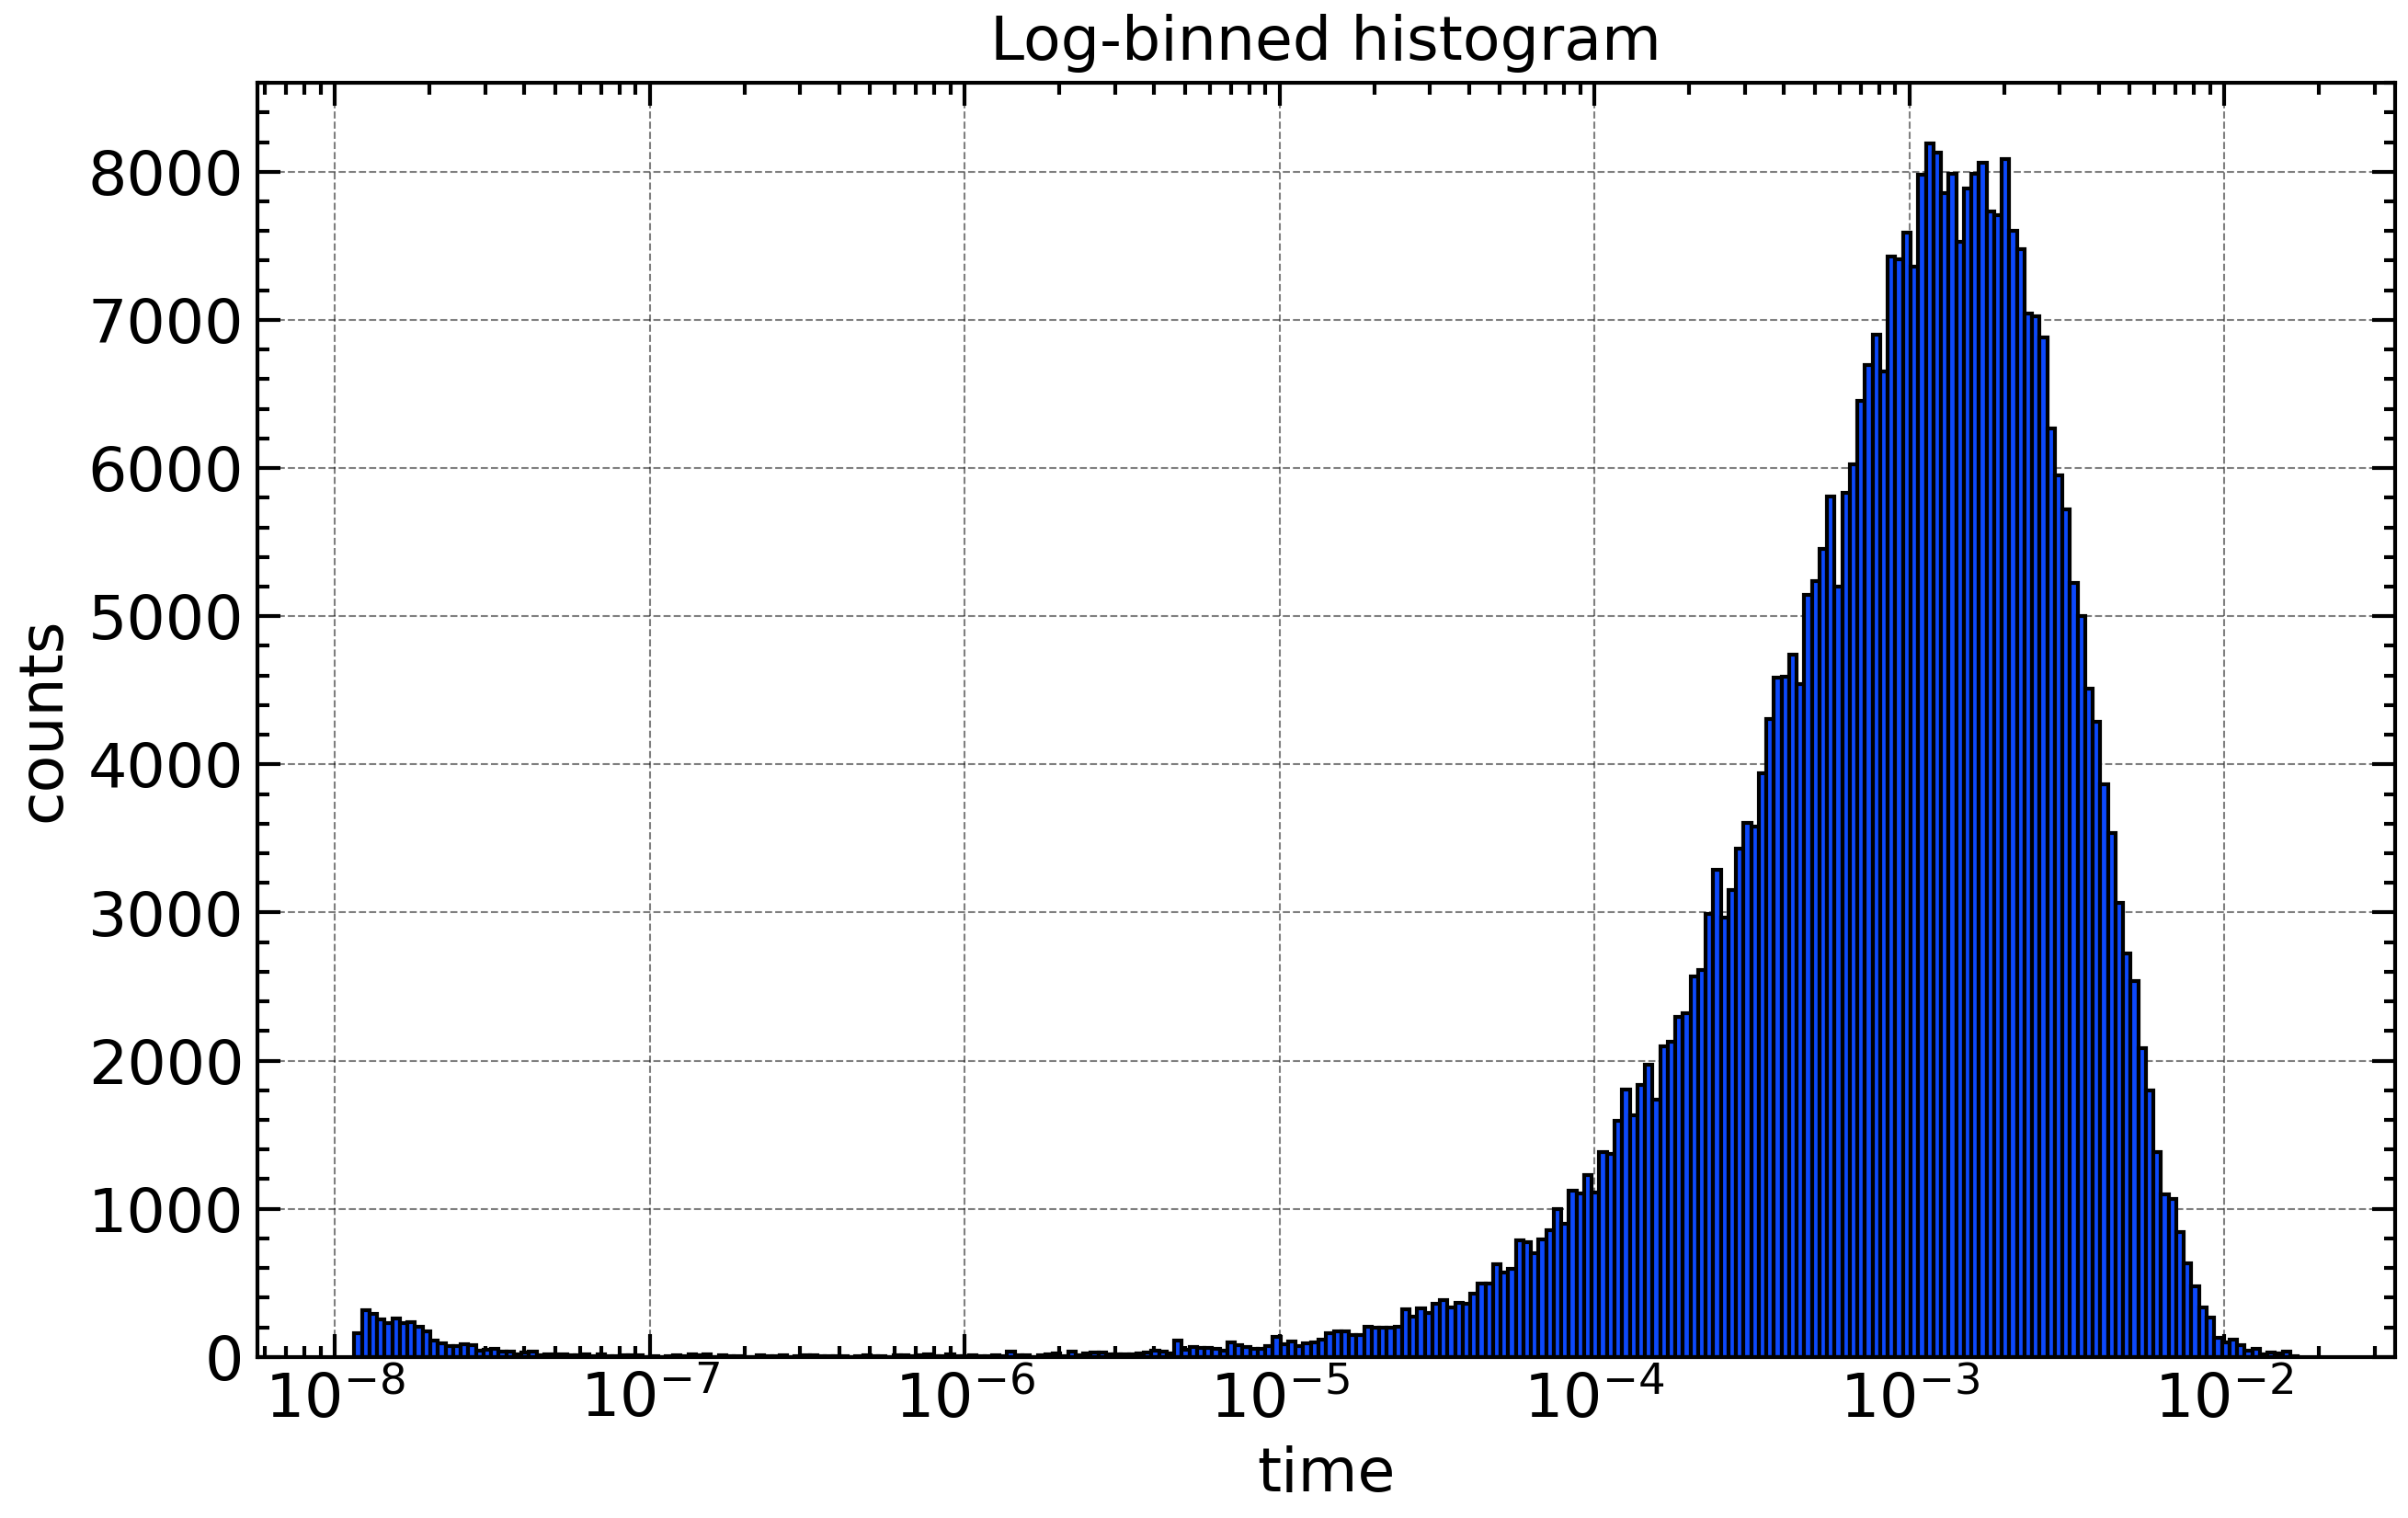

In [4]:
# Prepare timestamps: ensure numeric, finite, and strictly positive (log bins require > 0)
t = np.asarray(detector1_times, dtype=float)
t = t[np.isfinite(t)]
t = t[t > 0]

if t.size == 0:
    raise ValueError("No positive timestamps found in detector1_times; cannot compute log bins.")

# Number of log bins (adjust as needed)
nbins = 256

edges = np.logspace(np.log10(t.min()), np.log10(t.max()), nbins + 1)

# Compute histogram counts in log-spaced bins
counts, edges = np.histogram(t, bins=edges)
centers = (edges[:-1] + edges[1:]) / 2
widths = edges[1:] - edges[:-1]

# Make a DataFrame for easy inspection
hist_df = pd.DataFrame(
    {
        "count": counts,
        "left": edges[:-1],
        "right": edges[1:],
        "center": centers,
        "width": widths,
    }
)

# Optional: plot the histogram on a log x-axis
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.bar(centers, counts, width=widths, align="center", edgecolor="k")
ax.set_xscale("log")
ax.set_xlabel("time")
ax.set_ylabel("counts")
ax.set_title("Log-binned histogram")

out_dir = Path("../results/figures")
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / "simple_collision_track_analysis_log_histogram_detector.png"
plt.savefig(out_file, bbox_inches="tight")

## Export binned data to excel

In [5]:
out_dir = Path("../results/data")
out_dir.mkdir(parents=True, exist_ok=True)

out_file = out_dir / "collision_track_binned.xlsx"
hist_df.to_excel(out_file, index=False)
print(f"Saved {len(hist_df)} rows to {out_file}")

Saved 256 rows to ../results/data/collision_track_binned.xlsx


## Variance to mean ratio attempt

In [6]:
def calculate_feynman_y_pulsed(timestamps, gate_widths, time_windows=None, 
                                pulse_period=None):
    """
    Calculate Feynman-Y for pulsed neutron source data.
    
    Parameters:
    -----------
    timestamps : array-like
        Neutron detection times (absolute or relative to pulse start)
    gate_widths : array-like
        Gate widths to evaluate (same units as timestamps)
    time_windows : dict, optional
        Time windows as {label: (t_start, t_end), ...}
        Example: {"prompt": (1e-3, 1e-1), "delayed": (1e-1, 10)}
        If None, analyzes full time range as "full"
    pulse_period : float, optional
        Period between pulses. If provided, data is folded modulo this period
        
    Returns:
    --------
    results : dict
        results[window_label][variable_name] = array
        where variable_name is one of: 'Y', 'variance', 'mean', 'gate_widths'
    """
    timestamps = np.asarray(timestamps)
    gate_widths = np.asarray(gate_widths)
    
    # Normalize timestamps if multiple pulses
    if pulse_period is not None:
        timestamps = timestamps % pulse_period
    
    # Define default time window if not provided
    if time_windows is None:
        time_windows = {"full": (timestamps.min(), timestamps.max())}
    
    results = {}
    
    for window_label, (window_start, window_end) in time_windows.items():
        # Filter timestamps to this window
        window_timestamps = timestamps[
            (timestamps >= window_start) & (timestamps < window_end)
        ]
        
        Y_values = []
        var_values = []
        mean_values = []
        valid_gates = []
        
        for gate_width in gate_widths:
            # Create bins for this gate width
            bins = np.arange(window_start, window_end, gate_width)
            
            if len(bins) < 2:
                continue  # Skip if gate too large for window
            
            # Count neutrons in each gate
            counts, _ = np.histogram(window_timestamps, bins=bins)
            
            # Calculate statistics
            mean_count = np.mean(counts)
            var_count = np.var(counts, ddof=1)
            
            if mean_count > 0:
                Y = var_count / mean_count - 1
                Y_values.append(Y)
                var_values.append(var_count)
                mean_values.append(mean_count)
                valid_gates.append(gate_width)
        
        # Store results for this window
        results[window_label] = {
            'Y': np.array(Y_values),
            'variance': np.array(var_values),
            'mean': np.array(mean_values),
            'gate_widths': np.array(valid_gates)
        }
    
    return results


# Simplified usage example
def analyze_pulsed_feynman_y(timestamps, pulse_period=None):
    """
    Complete analysis for pulsed neutron source with your three peaks.
    """
    # Define gate widths
    gate_widths = np.logspace(-5, 2, 50)
    
    # Define regions based on your histogram
    time_windows = {
        "prompt": (1e-3, 1e-1),
        "delayed": (1e-1, 1e2),
    }
    
    results = calculate_feynman_y_pulsed(
        timestamps, 
        gate_widths,
        time_windows=time_windows,
        pulse_period=pulse_period
    )
    
    return results


# Quick plotting helper
def plot_feynman_results(results):
    """Plot Feynman-Y vs gate width for all windows."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for window_label, data in results.items():
        axes[0].loglog(data['gate_widths'], data['Y'], 
                       marker='o', label=window_label)
        axes[1].loglog(data['gate_widths'], data['variance'], 
                       marker='o', label=window_label)
        axes[2].loglog(data['gate_widths'], data['mean'], 
                       marker='o', label=window_label)
    
    axes[0].set_xlabel('Gate width')
    axes[0].set_ylabel('Feynman Y')
    axes[0].legend()
    
    axes[1].set_xlabel('Gate width')
    axes[1].set_ylabel('Variance')
    axes[1].legend()
    
    axes[2].set_xlabel('Gate width')
    axes[2].set_ylabel('Mean counts')
    axes[2].legend()
    
    plt.tight_layout()
    return fig


/home/itay/miniforge3/envs/openmc-env/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/itay/miniforge3/envs/openmc-env/lib/python3.11/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


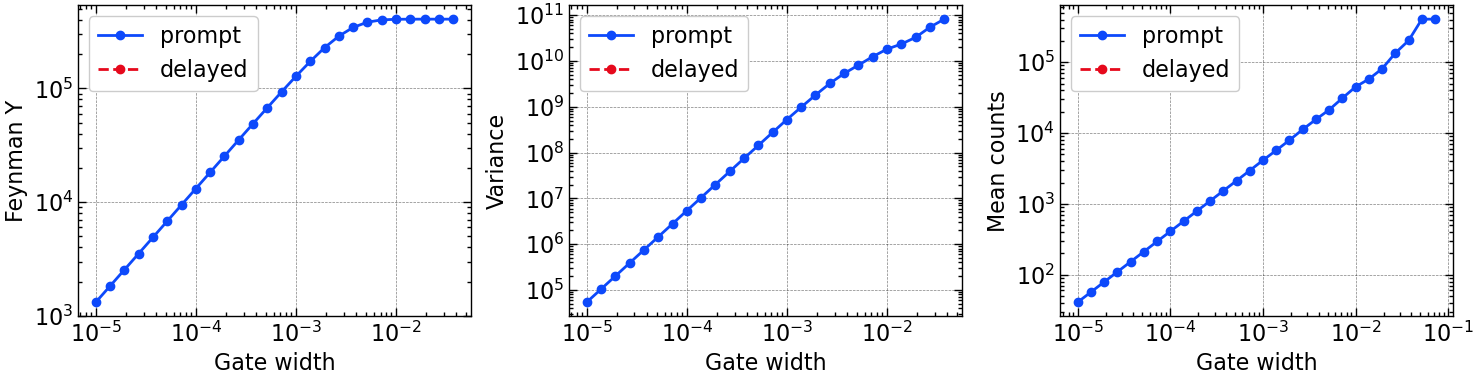

In [7]:
results = analyze_pulsed_feynman_y(timestamps)

# fig = plot_feynman_results({"prompt": results["prompt"]})
fig = plot_feynman_results(results)

In [8]:
from rich import print as rprint
from rich.tree import Tree

def dict_to_tree(d, tree=None, name="root"):
    """Convert nested dict to a Rich tree for beautiful visualization."""
    if tree is None:
        tree = Tree(f"[bold]{name}[/bold]")
    
    for key, value in d.items():
        if isinstance(value, dict):
            branch = tree.add(f"[cyan]{key}[/cyan] (dict, {len(value)} keys)")
            dict_to_tree(value, branch, key)
        elif isinstance(value, (list, tuple)):
            type_name = type(value).__name__
            branch = tree.add(f"[green]{key}[/green]: {type_name}(len={len(value)})")
        elif hasattr(value, 'shape'):
            branch = tree.add(f"[yellow]{key}[/yellow]: {type(value).__name__}{value.shape}")
        else:
            branch = tree.add(f"[white]{key}[/white]: {type(value).__name__}")
    
    return tree

# Usage
from rich.console import Console
console = Console()
tree = dict_to_tree(results, name="results")
console.print(tree)

results
├── prompt (dict, 4 keys)
│   ├── Y: ndarray(28,)
│   ├── variance: ndarray(28,)
│   ├── mean: ndarray(28,)
│   └── gate_widths: ndarray(28,)
└── delayed (dict, 4 keys)
    ├── Y: ndarray(0,)
    ├── variance: ndarray(0,)
    ├── mean: ndarray(0,)
    └── gate_widths: ndarray(0,)